# Using a calibrated flow model to predict $z_{\rm cosmo}$

In [1]:
# Copyright (C) 2024 Richard Stiskalek
# This program is free software; you can redistribute it and/or modify it
# under the terms of the GNU General Public License as published by the
# Free Software Foundation; either version 3 of the License, or (at your
# option) any later version.
#
# This program is distributed in the hope that it will be useful, but
# WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the GNU General
# Public License for more details.
#
# You should have received a copy of the GNU General Public License along
# with this program; if not, write to the Free Software Foundation, Inc.,
# 51 Franklin Street, Fifth Floor, Boston, MA  02110-1301, USA.
import numpy as np
import matplotlib.pyplot as plt
from h5py import File

import csiborgtools

%load_ext autoreload
%autoreload 2
%matplotlib inline

paths = csiborgtools.read.Paths(**csiborgtools.paths_glamdring)

In [18]:
def load_calibration(catalogue, simname, nsim, ksmooth):
    fname = f"/mnt/extraspace/rstiskalek/csiborg_postprocessing/peculiar_velocity/flow_samples_{catalogue}_{simname}_smooth_{ksmooth}.hdf5"  # noqa
    keys = ["Vext_x", "Vext_y", "Vext_z", "alpha", "beta", "sigma_v"]

    
    SN_keys = ['mag_cal', 'alpha_cal', 'beta_cal']
    calibration_samples = {}
    with File(fname, 'r') as f:
        for key in keys:
            calibration_samples[key] = f[f"sim_{nsim}/{key}"][:]

        for key in SN_keys:
            calibration_samples[key] = f[f"sim_{nsim}/{key}"][:]

    return calibration_samples

## Test running a model

In [138]:
fpath_data = "/mnt/extraspace/rstiskalek/catalogs/PV_compilation_Supranta2019.hdf5"

simname = "csiborg2_main"
catalogue = "Pantheon+"
nsim = 17417
loader = csiborgtools.flow.DataLoader(simname, 19, catalogue, fpath_data, paths, ksmooth=1)

calibration_samples = load_calibration(catalogue, simname, nsim, 1)
flow_model = csiborgtools.flow.get_model(loader, zcmb_max=0.07)

09:40:04: reading the catalogue.
09:40:04: reading the interpolated field.
09:40:04: calculating the radial velocity.
Selected 697/741 galaxies.


/mnt/users/rstiskalek/csiborgtools/csiborgtools/flow/flow_model.py:113: UserWarning: The number of radial steps is even. Skipping the first step at 0.0 because Simpson's rule requires an odd number of steps.
  warn(f"The number of radial steps is even. Skipping the first "


In [139]:
model = csiborgtools.flow.Observed2CosmologicalRedshift(calibration_samples, loader.rdist, loader._Omega_m)

In [140]:
zcosmo_mean, zcosmo_std = flow_model.predict_zcosmo_from_calibration(
    calibration_samples["mag_cal"], calibration_samples["alpha_cal"], calibration_samples["beta_cal"])

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:04<00:00, 2161.99it/s]


In [143]:
# n = 2 is a very good test

n = 10
zcos, post = model.posterior_zcosmo(
    loader.cat["zCMB"][n], loader.cat["RA"][n], loader.cat["DEC"][n],
    loader.los_density[n], loader.los_radial_velocity[n])

Marginalizing: 100%|██████████| 10000/10000 [00:04<00:00, 2055.82it/s]


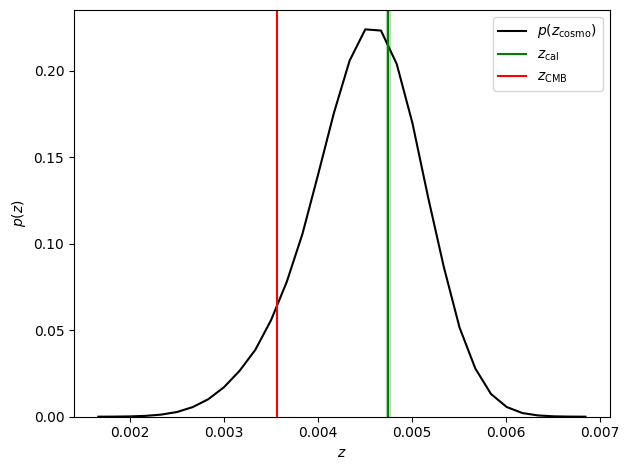

In [144]:
plt.figure()

mask = post > 1e-5
plt.plot(zcos[mask], post[mask], color="black", label=r"$p(z_{\rm cosmo})$")


plt.ylim(0)
plt.axvline(zcosmo_mean[n], color="green", label=r"$z_{\rm cal}$")
plt.fill_betweenx([0, plt.ylim()[1]], zcosmo_mean[n] - zcosmo_std[n],
                  zcosmo_mean[n] + zcosmo_std[n], color="green", alpha=0.2)
plt.axvline(loader.cat["zCMB"][n], color="red", label=r"$z_{\rm CMB}$")

plt.xlabel(r"$z$")
plt.ylabel(r"$p(z)$")
plt.legend()
plt.tight_layout()
# plt.savefig("../plots/zcosmo_posterior.png", dpi=450)
plt.show()